In [ ]:
pip install fbprophet

^C
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 35, in <module>
        File "C:\Users\Manav Singh\AppData\Local\Temp\pip-install-65hwrn1g\pystan_72c5ac4290b7491fad03f0f59bb8fb82\setup.py", line 122, in <module>
          from Cython.Build.Inline import _get_build_extension
      ModuleNotFoundError: No module named 'Cython'
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached cython-3.1.2-cp312-cp312-win_amd64.whl.metadata (6.0 kB)
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached pystan-3.10.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached PyMeeus-0.5.12.tar.gz (5.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached ephem-4.2-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl.metadata (1.6 kB)
INFO: pip is looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
  Using 

In [ ]:
pip install Prophet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Essential libraries for sales forecasting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Time series and ML libraries
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller



In [3]:
# Load your retail sales dataset
# Option 1: Superstore dataset
df = pd.read_csv('Superstore.csv',encoding='ISO-8859-1')

# Option 2: Custom retail dataset
# df = pd.read_csv('retail_sales_data.csv')

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(df.head())


Dataset loaded successfully!
Shape: (9994, 21)
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156  11-08-2016  11-11-2016    Second Class    CG-12520   
1       2  CA-2016-152156  11-08-2016  11-11-2016    Second Class    CG-12520   
2       3  CA-2016-138688  06-12-2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10-11-2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10-11-2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID       

In [4]:
# Data cleaning function
def clean_sales_data(df):
    # Convert date columns to datetime
    if 'Order Date' in df.columns:
        df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y', errors='coerce')

    elif 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
    
    # Handle missing values
    print("Missing values before cleaning:")
    print(df.isnull().sum())
    
    # Remove or fill missing values based on business logic
    df = df.dropna(subset=['Sales'])  # Remove rows with missing sales
    
    # Fill categorical missing values with mode
    for col in df.select_dtypes(include=['object']).columns:
        df[col].fillna(df[col].mode()[0], inplace=True)
    
    # Fill numerical missing values with median
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Remove duplicates
    df = df.drop_duplicates()
    
    # Handle outliers using IQR method
    Q1 = df['Sales'].quantile(0.25)
    Q3 = df['Sales'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df['Sales'] >= lower_bound) & (df['Sales'] <= upper_bound)]
    
    return df

# Apply cleaning
df_clean = clean_sales_data(df)
print(f"Cleaned dataset shape: {df_clean.shape}")


Missing values before cleaning:
Row ID              0
Order ID            0
Order Date       4042
Ship Date           0
Ship Mode           0
Customer ID         0
Customer Name       0
Segment             0
Country             0
City                0
State               0
Postal Code         0
Region              0
Product ID          0
Category            0
Sub-Category        0
Product Name        0
Sales               0
Quantity            0
Discount            0
Profit              0
dtype: int64
Cleaned dataset shape: (8827, 21)


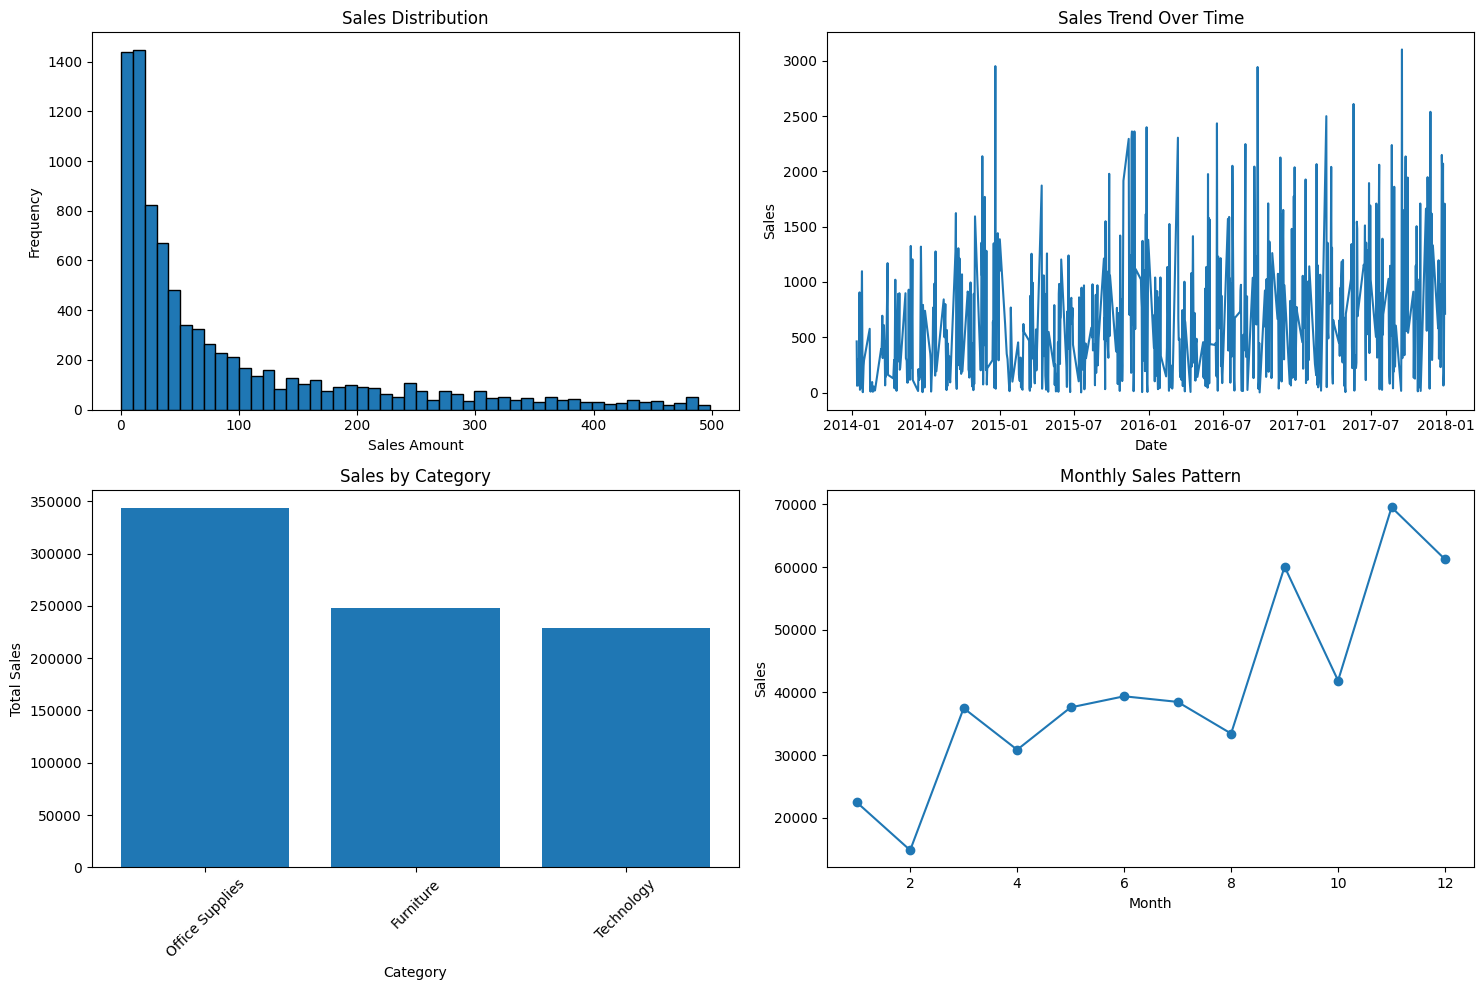

In [5]:
# EDA function for sales data
def perform_eda(df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Sales distribution
    axes[0,0].hist(df['Sales'], bins=50, edgecolor='black')
    axes[0,0].set_title('Sales Distribution')
    axes[0,0].set_xlabel('Sales Amount')
    axes[0,0].set_ylabel('Frequency')
    
    # Sales over time
    if 'Order Date' in df.columns:
        date_col = 'Order Date'
    else:
        date_col = 'Date'
    
    daily_sales = df.groupby(date_col)['Sales'].sum().reset_index()
    axes[0,1].plot(daily_sales[date_col], daily_sales['Sales'])
    axes[0,1].set_title('Sales Trend Over Time')
    axes[0,1].set_xlabel('Date')
    axes[0,1].set_ylabel('Sales')
    
    # Category-wise sales
    if 'Category' in df.columns:
        category_sales = df.groupby('Category')['Sales'].sum().sort_values(ascending=False)
        axes[1,0].bar(category_sales.index, category_sales.values)
        axes[1,0].set_title('Sales by Category')
        axes[1,0].set_xlabel('Category')
        axes[1,0].set_ylabel('Total Sales')
        axes[1,0].tick_params(axis='x', rotation=45)
    
    # Monthly sales pattern
    df['Month'] = df[date_col].dt.month
    monthly_sales = df.groupby('Month')['Sales'].sum()
    axes[1,1].plot(monthly_sales.index, monthly_sales.values, marker='o')
    axes[1,1].set_title('Monthly Sales Pattern')
    axes[1,1].set_xlabel('Month')
    axes[1,1].set_ylabel('Sales')
    
    plt.tight_layout()
    plt.show()
    
    return daily_sales

daily_sales = perform_eda(df_clean)


In [6]:
print(daily_sales.columns)


Index(['Order Date', 'Sales'], dtype='object')


In [7]:
def engineer_time_features(df, date_col='Date'):
    """Create comprehensive time-based features for forecasting"""

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # Basic time features
    df['Year'] = df[date_col].dt.year
    df['Month'] = df[date_col].dt.month
    df['Day'] = df[date_col].dt.day
    df['DayOfWeek'] = df[date_col].dt.dayofweek
    df['Quarter'] = df[date_col].dt.quarter
    df['WeekOfYear'] = df[date_col].dt.isocalendar().week.astype(int)
    df['DayOfYear'] = df[date_col].dt.dayofyear
    df['DayName'] = df[date_col].dt.day_name()
    df['MonthName'] = df[date_col].dt.month_name()

    # Cyclical features
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    # Weekend and special time flags
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['IsMonthEnd'] = df[date_col].dt.is_month_end.astype(int)
    df['IsMonthStart'] = df[date_col].dt.is_month_start.astype(int)

    # Retail holiday periods
    df['IsHolidaySeason'] = ((df['Month'] == 12) | (df['Month'] == 11)).astype(int)
    df['IsBackToSchool'] = ((df['Month'] == 8) | (df['Month'] == 9)).astype(int)

    return df

# Usage:
df_features = engineer_time_features(daily_sales, date_col='Order Date')
print("Time-based features created:")
print(df_features.columns.tolist())


Time-based features created:
['Order Date', 'Sales', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'WeekOfYear', 'DayOfYear', 'DayName', 'MonthName', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'IsWeekend', 'IsMonthEnd', 'IsMonthStart', 'IsHolidaySeason', 'IsBackToSchool']


In [8]:
print(df_features.columns)


Index(['Order Date', 'Sales', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter',
       'WeekOfYear', 'DayOfYear', 'DayName', 'MonthName', 'Month_sin',
       'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'IsWeekend',
       'IsMonthEnd', 'IsMonthStart', 'IsHolidaySeason', 'IsBackToSchool'],
      dtype='object')


In [9]:
def create_lag_features(df, target_col='Sales', lags=[1, 7, 14, 30], date_col='Order Date'):
    """Create lag features and rolling statistics"""

    df = df.copy()
    df = df.sort_values(date_col)      # <--- FIXED!
    
    # Lag features
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    
    # Rolling window features
    windows = [7, 14, 30, 90]
    for window in windows:
        df[f'{target_col}_rolling_mean_{window}'] = df[target_col].rolling(window=window).mean()
        df[f'{target_col}_rolling_std_{window}'] = df[target_col].rolling(window=window).std()
        df[f'{target_col}_rolling_min_{window}'] = df[target_col].rolling(window=window).min()
        df[f'{target_col}_rolling_max_{window}'] = df[target_col].rolling(window=window).max()
    
    # Trend features
    for window in [7, 30]:
        df[f'{target_col}_trend_{window}'] = df[target_col] / df[f'{target_col}_rolling_mean_{window}']
    
    # Remove rows with NaN values created by lag and rolling features
    df = df.dropna()
    
    return df


In [10]:
df_final = create_lag_features(df_features, date_col='Order Date')
print(f"Final dataset shape after feature engineering: {df_final.shape}")

Final dataset shape after feature engineering: (658, 42)


In [11]:
df_final = create_lag_features(df_features, date_col='Order Date')


In [12]:
print(df.columns)


Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')


17:38:11 - cmdstanpy - INFO - Chain [1] start processing
17:38:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Performance:
MAE: 518.20
RMSE: 665.82
MAPE: 363.99%


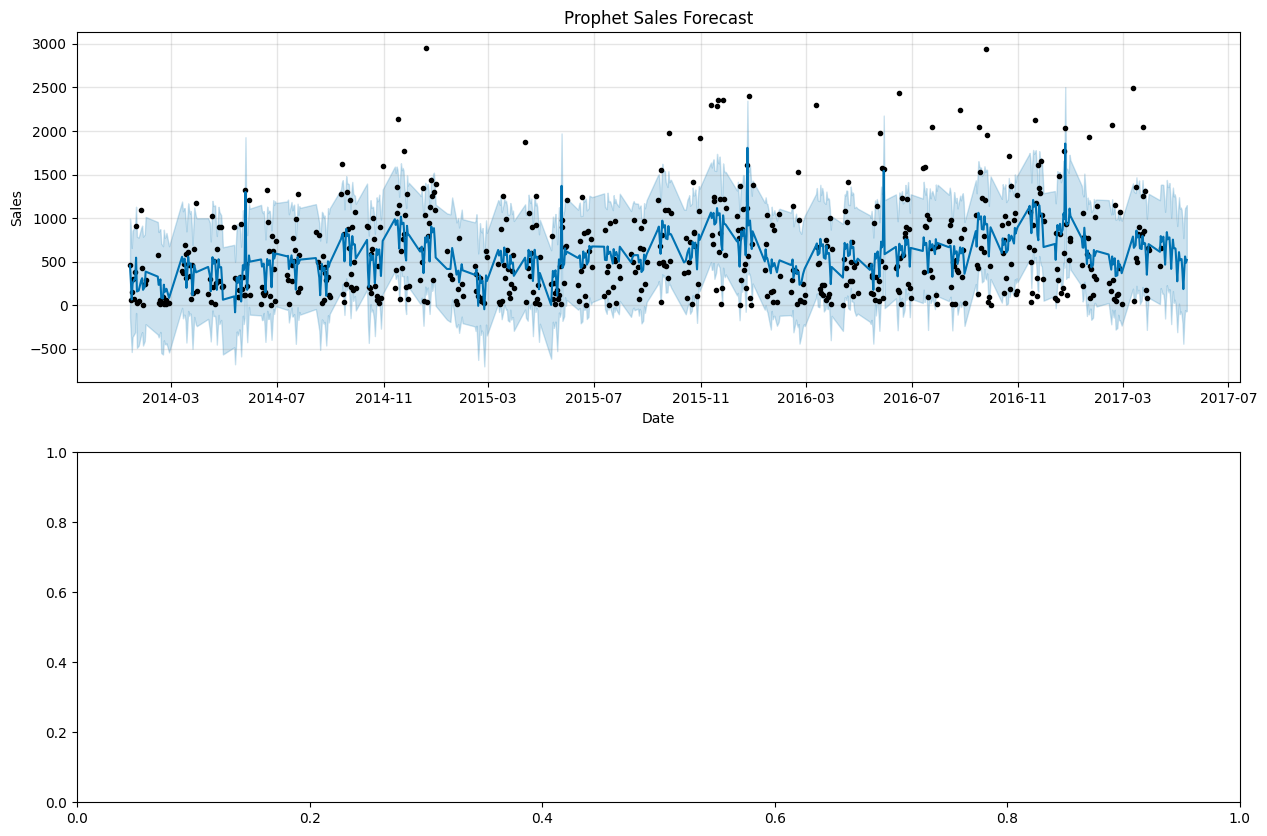

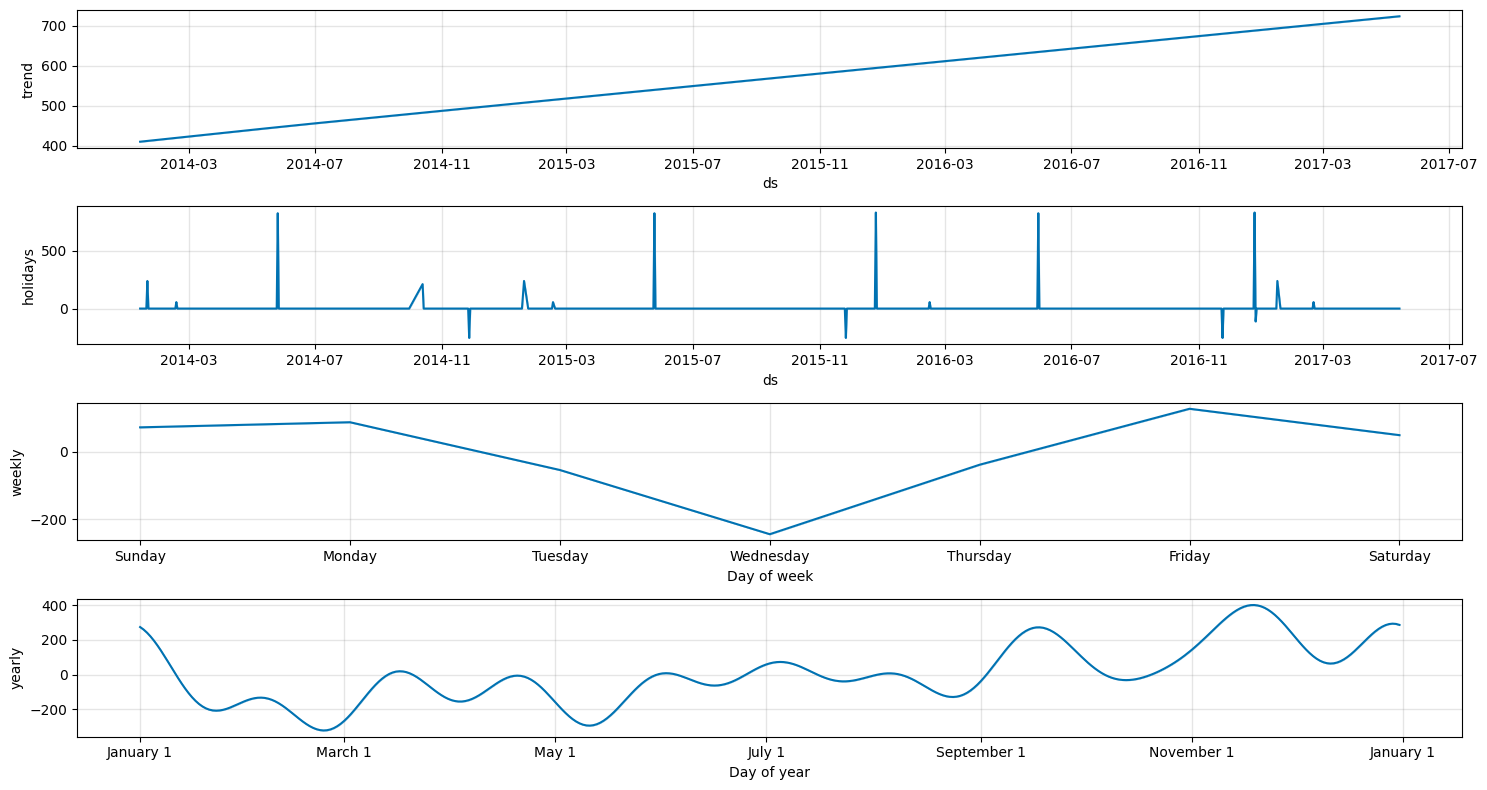

In [13]:
def implement_prophet_forecast(df, forecast_periods=30):
    """Implement Facebook Prophet forecasting model"""
    
    # Prepare data for Prophet (requires 'ds' and 'y' columns)
    prophet_data = df[['Order Date', 'Sales']].copy()

    prophet_data.columns = ['ds', 'y']
    
    # Split data for training and validation
    train_size = int(len(prophet_data) * 0.8)
    train_data = prophet_data[:train_size]
    test_data = prophet_data[train_size:]
    
    # Initialize and configure Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='additive',  # Can be 'multiplicative' for exponential growth
        changepoint_prior_scale=0.05  # Controls trend flexibility
    )
    
    # Add custom seasonalities and holidays if needed
    model.add_country_holidays(country_name='US')  # Add US holidays
    
    # Fit the model
    model.fit(train_data)
    
    # Make predictions on test set
    future_test = model.make_future_dataframe(periods=len(test_data), freq='D')
    forecast_test = model.predict(future_test)
    
    # Calculate validation metrics
    y_true = test_data['y'].values
    y_pred = forecast_test['yhat'][-len(test_data):].values
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"Prophet Model Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    # Make future predictions
    future_full = model.make_future_dataframe(periods=forecast_periods, freq='D')
    forecast_full = model.predict(future_full)
    
    # Visualize results
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot forecast
    model.plot(forecast_full, ax=axes[0])
    axes[0].set_title('Prophet Sales Forecast')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Sales')
    
    # Plot components
    model.plot_components(forecast_full, figsize=(15, 8))
    plt.show()
    
    return model, forecast_full, {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Implement Prophet forecasting
prophet_model, prophet_forecast, prophet_metrics = implement_prophet_forecast(daily_sales)


Checking stationarity of original series:
ADF Statistic: -5.621375285967449
p-value: 1.1430643534582678e-06
Series is stationary


c:\Users\Manav Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Manav Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Manav Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  597
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4578.358
Date:                Mon, 21 Jul 2025   AIC                           9166.715
Time:                        17:38:16   BIC                           9188.666
Sample:                             0   HQIC                          9175.263
                                - 597                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9944      0.251     -3.961      0.000      -1.487      -0.502
ar.L2         -0.0030      0.042     -0.072      0.943      -0.086       0.080
ma.L1          0.0397      0.2

c:\Users\Manav Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Manav Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


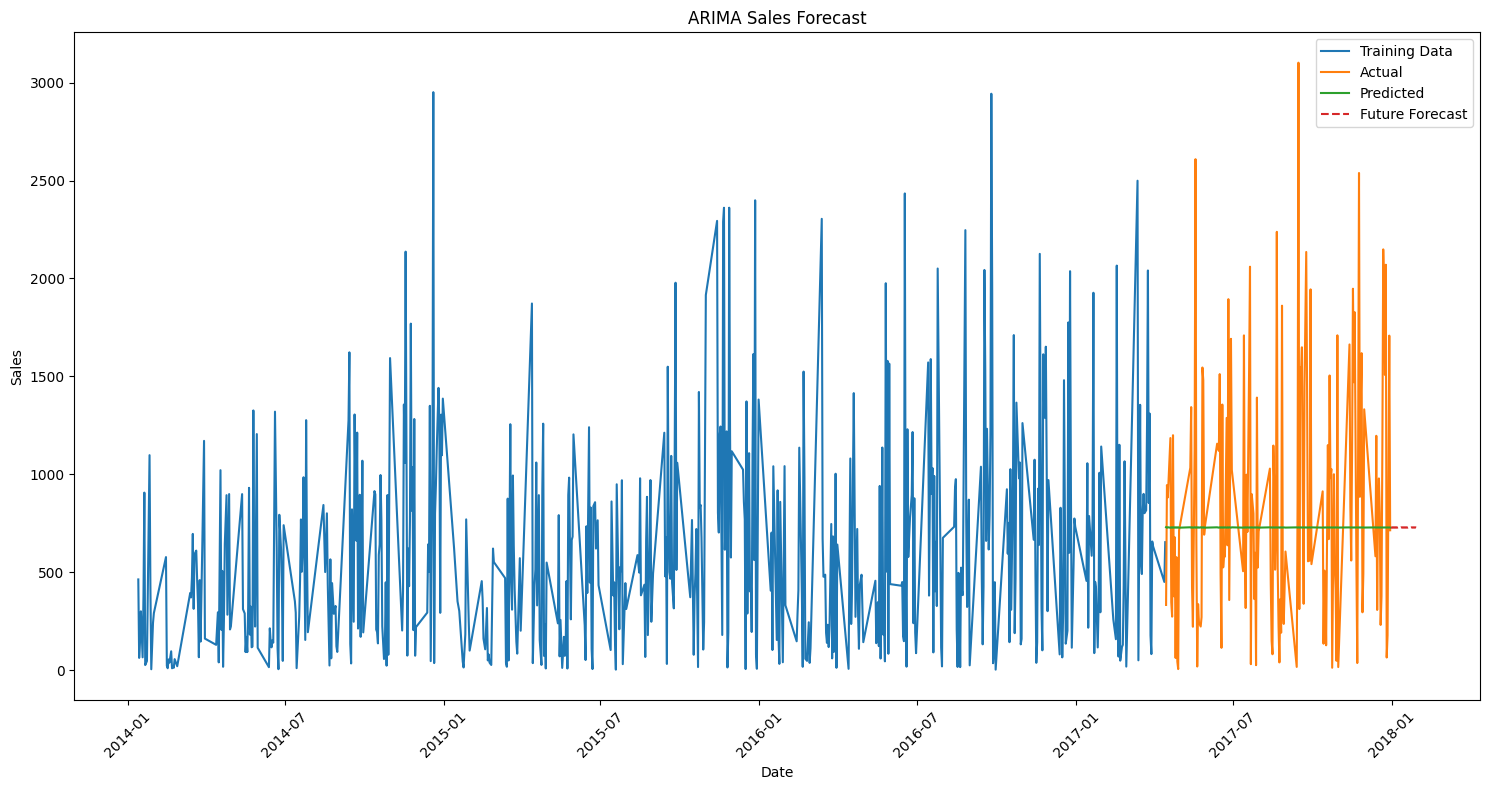

In [14]:
def implement_arima_forecast(df, forecast_periods=30):
    """Implement ARIMA forecasting model"""
    
    # Prepare data
    sales_series = df.set_index('Order Date')['Sales']
    
    # Check stationarity
    def check_stationarity(timeseries):
        result = adfuller(timeseries)
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        if result[1] <= 0.05:
            print("Series is stationary")
        else:
            print("Series is non-stationary")
        return result[1] <= 0.05
    
    print("Checking stationarity of original series:")
    is_stationary = check_stationarity(sales_series)
    
    # Make series stationary if needed
    if not is_stationary:
        sales_diff = sales_series.diff().dropna()
        print("\nChecking stationarity after differencing:")
        check_stationarity(sales_diff)
    
    # Split data
    train_size = int(len(sales_series) * 0.8)
    train_data = sales_series[:train_size]
    test_data = sales_series[train_size:]
    
    # Fit ARIMA model (you may need to tune these parameters)
    try:
        model = ARIMA(train_data, order=(2, 1, 2))  # (p, d, q)
        fitted_model = model.fit()
        
        print("\nARIMA Model Summary:")
        print(fitted_model.summary())
        
        # Make predictions
        forecast_result = fitted_model.forecast(steps=len(test_data))
        y_pred = forecast_result
        y_true = test_data.values
        
        # Calculate metrics
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
        print(f"\nARIMA Model Performance:")
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAPE: {mape:.2f}%")
        
        # Future forecast
        future_forecast = fitted_model.forecast(steps=forecast_periods)
        
        # Plot results
        plt.figure(figsize=(15, 8))
        plt.plot(train_data.index, train_data, label='Training Data')
        plt.plot(test_data.index, test_data, label='Actual')
        plt.plot(test_data.index, y_pred, label='Predicted')
        
        # Plot future forecast
        future_dates = pd.date_range(sales_series.index[-1] + timedelta(days=1), 
                                   periods=forecast_periods, freq='D')
        plt.plot(future_dates, future_forecast, label='Future Forecast', linestyle='--')
        
        plt.legend()
        plt.title('ARIMA Sales Forecast')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return fitted_model, future_forecast, {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}
        
    except Exception as e:
        print(f"Error fitting ARIMA model: {e}")
        return None, None, None

# Implement ARIMA forecasting
arima_model, arima_forecast, arima_metrics = implement_arima_forecast(daily_sales)


In [15]:
def implement_xgboost_forecast(df, forecast_periods=30, date_col='Order Date', target_col='Sales'):
    # Remove date, string, and object columns from features
    ignored_cols = [date_col, target_col, 'DayName', 'MonthName']  # Add further non-numeric columns as relevant
    feature_cols = [col for col in df.columns
                    if col not in ignored_cols
                    and pd.api.types.is_numeric_dtype(df[col])]
    
    X = df[feature_cols]
    y = df[target_col]

    # Split data chronologically
    train_size = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Initialize XGBoost model
    model = xgb.XGBRegressor(
        n_estimators=1000,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping_rounds=50
    )

    # Train model
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"XGBoost Model Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
    plt.title('XGBoost Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    # Plot predictions vs actual
    plt.figure(figsize=(15, 8))
    test_dates = df[date_col].iloc[train_size:].values
    plt.plot(test_dates, y_test, label='Actual', alpha=0.7)
    plt.plot(test_dates, y_pred, label='Predicted', alpha=0.7)
    plt.legend()
    plt.title('XGBoost Sales Forecast - Test Set')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return model, {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}


XGBoost Model Performance:
MAE: 83.25
RMSE: 145.57
MAPE: 10.98%

Top 10 Most Important Features:
                  feature  importance
37         Sales_trend_30    0.613910
36          Sales_trend_7    0.114239
23    Sales_rolling_max_7    0.078700
21    Sales_rolling_std_7    0.047631
28  Sales_rolling_mean_30    0.036913
27   Sales_rolling_max_14    0.029404
20   Sales_rolling_mean_7    0.021691
25   Sales_rolling_std_14    0.011358
24  Sales_rolling_mean_14    0.010383
29   Sales_rolling_std_30    0.009165


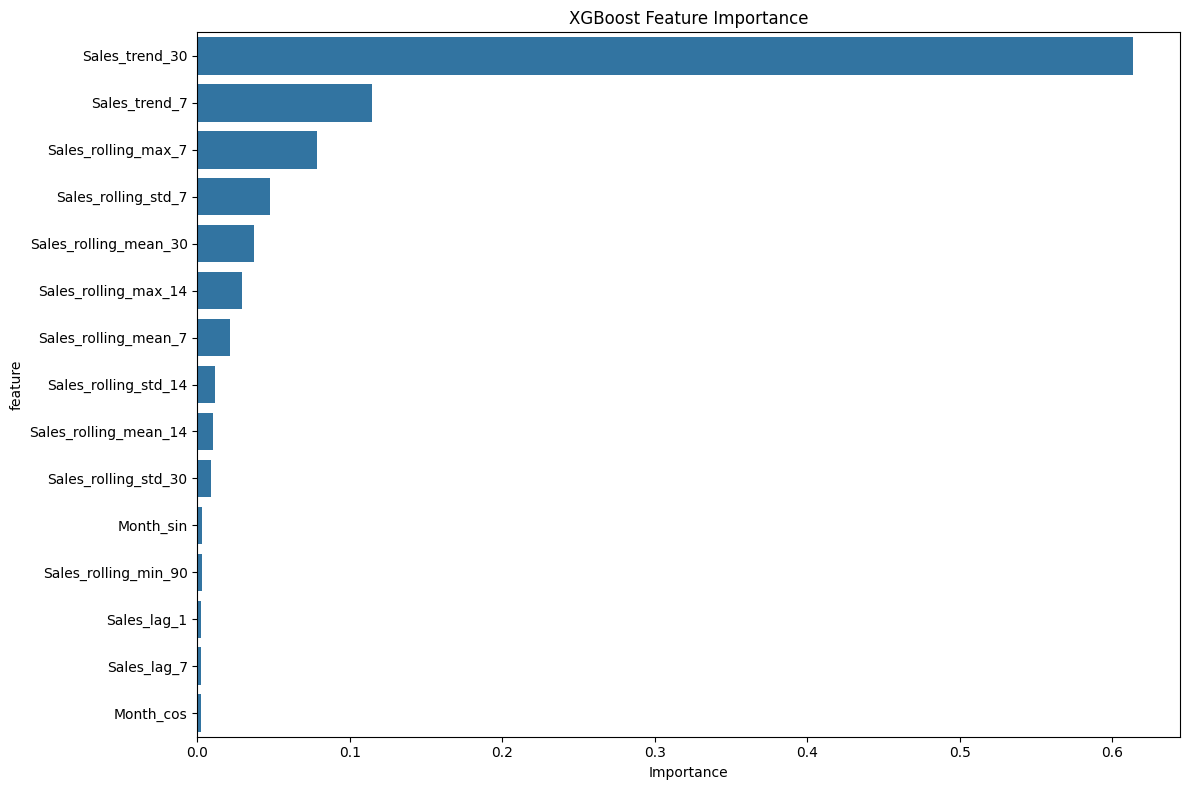

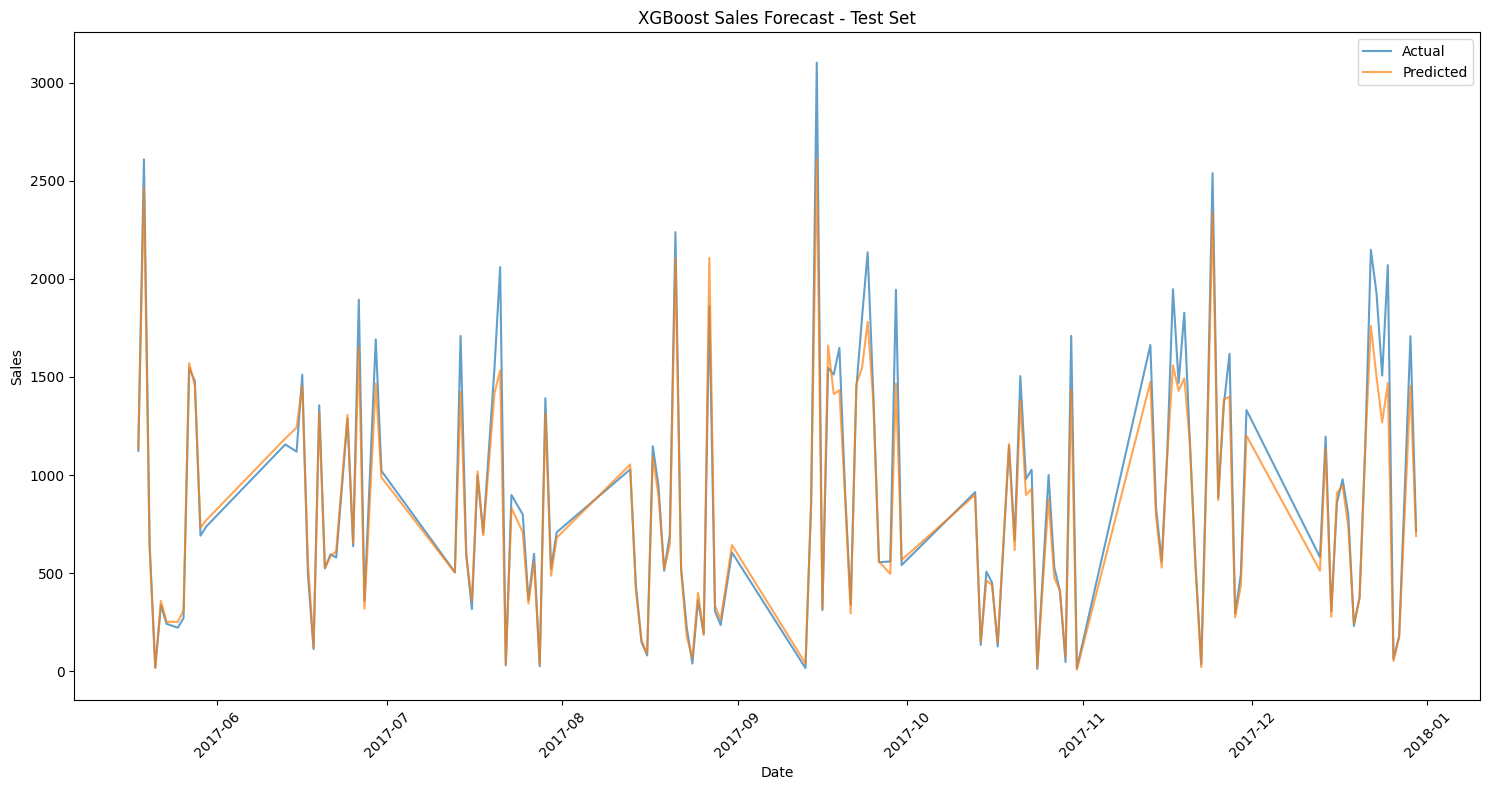

In [16]:
xgb_model, xgb_metrics = implement_xgboost_forecast(df_final, date_col='Order Date')


In [17]:
# df_final.rename(columns={'Order Date': 'Date'}, inplace=True)
# xgb_model, xgb_metrics = implement_xgboost_forecast(df_final, date_col='Date')


In [18]:
print(df_final.columns)


Index(['Order Date', 'Sales', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter',
       'WeekOfYear', 'DayOfYear', 'DayName', 'MonthName', 'Month_sin',
       'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'IsWeekend',
       'IsMonthEnd', 'IsMonthStart', 'IsHolidaySeason', 'IsBackToSchool',
       'Sales_lag_1', 'Sales_lag_7', 'Sales_lag_14', 'Sales_lag_30',
       'Sales_rolling_mean_7', 'Sales_rolling_std_7', 'Sales_rolling_min_7',
       'Sales_rolling_max_7', 'Sales_rolling_mean_14', 'Sales_rolling_std_14',
       'Sales_rolling_min_14', 'Sales_rolling_max_14', 'Sales_rolling_mean_30',
       'Sales_rolling_std_30', 'Sales_rolling_min_30', 'Sales_rolling_max_30',
       'Sales_rolling_mean_90', 'Sales_rolling_std_90', 'Sales_rolling_min_90',
       'Sales_rolling_max_90', 'Sales_trend_7', 'Sales_trend_30'],
      dtype='object')


In [19]:
def prepare_powerbi_data(df, forecasts):
    """Prepare consolidated dataset for Power BI visualization"""
    
    # Create comprehensive dataset with actual and forecasted values
    powerbi_data = []
    
    # Add historical data
    for _, row in df.iterrows():
        powerbi_data.append({
            'Date': row['Order Date'],
            'Sales': row['Sales'],
            'Type': 'Actual',
            'Category': row.get('Category', 'All'),
            'Region': row.get('Region', 'All'),
            'Store': row.get('Store', 'All')
        })
    
    # Add forecast data (example with Prophet forecast)
    if 'prophet_forecast' in locals():
        future_dates = prophet_forecast['ds'][-30:]  # Last 30 forecast points
        future_values = prophet_forecast['yhat'][-30:]
        
        for date, value in zip(future_dates, future_values):
            powerbi_data.append({
                'Date': date,
                'Sales': value,
                'Type': 'Forecast',
                'Category': 'All',
                'Region': 'All',
                'Store': 'All'
            })
    
    # Convert to DataFrame
    powerbi_df = pd.DataFrame(powerbi_data)
    
    # Add additional calculated columns for dashboard
    powerbi_df['Year'] = pd.to_datetime(powerbi_df['Date']).dt.year
    powerbi_df['Month'] = pd.to_datetime(powerbi_df['Date']).dt.month
    powerbi_df['Quarter'] = pd.to_datetime(powerbi_df['Date']).dt.quarter
    powerbi_df['MonthName'] = pd.to_datetime(powerbi_df['Date']).dt.month_name()
    
    # Save for Power BI import
    powerbi_df.to_csv('powerbi_sales_forecast_data.csv', index=False)
    print("Power BI dataset prepared and saved as 'powerbi_sales_forecast_data.csv'")
    
    return powerbi_df

# Prepare Power BI data
if 'daily_sales' in locals():
    powerbi_data = prepare_powerbi_data(daily_sales, {})


Power BI dataset prepared and saved as 'powerbi_sales_forecast_data.csv'


In [20]:
# Power BI Python Script for Custom Forecasting
# This script can be used directly in Power BI's Python visual or R script

# Paste this code in Power BI Python Script Editor
# Required libraries (ensure these are installed in your Python environment)
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

# Input data from Power BI (automatically available as 'dataset')
df = dataset.copy()

# Data preparation
df['Date'] = pd.to_datetime(df['Order Date'])
df = df.sort_values('Date')

# Prepare data for Prophet
prophet_data = df[['Order Date', 'Sales']].copy()
prophet_data.columns = ['ds', 'y']

# Initialize and fit Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model.fit(prophet_data)

# Create future dataframe for forecasting
future = model.make_future_dataframe(periods=30, freq='D')
forecast = model.predict(future)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 6))
model.plot(forecast, ax=ax)
ax.set_title('Sales Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.tight_layout()
plt.show()

# Return forecast data to Power BI
forecast_output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)
forecast_output.columns = ['Date', 'Forecast', 'Lower_Bound', 'Upper_Bound']

print("Power BI Python script template created.")
print("Copy the script above into Power BI's Python visual editor.")


NameError: name 'dataset' is not defined

Model Performance Comparison:
  Model        MAE       RMSE       MAPE
Prophet 518.200390 665.822062 363.986954
  ARIMA 515.563422 652.771669 391.235533
XGBoost  83.253722 145.568179  10.980235


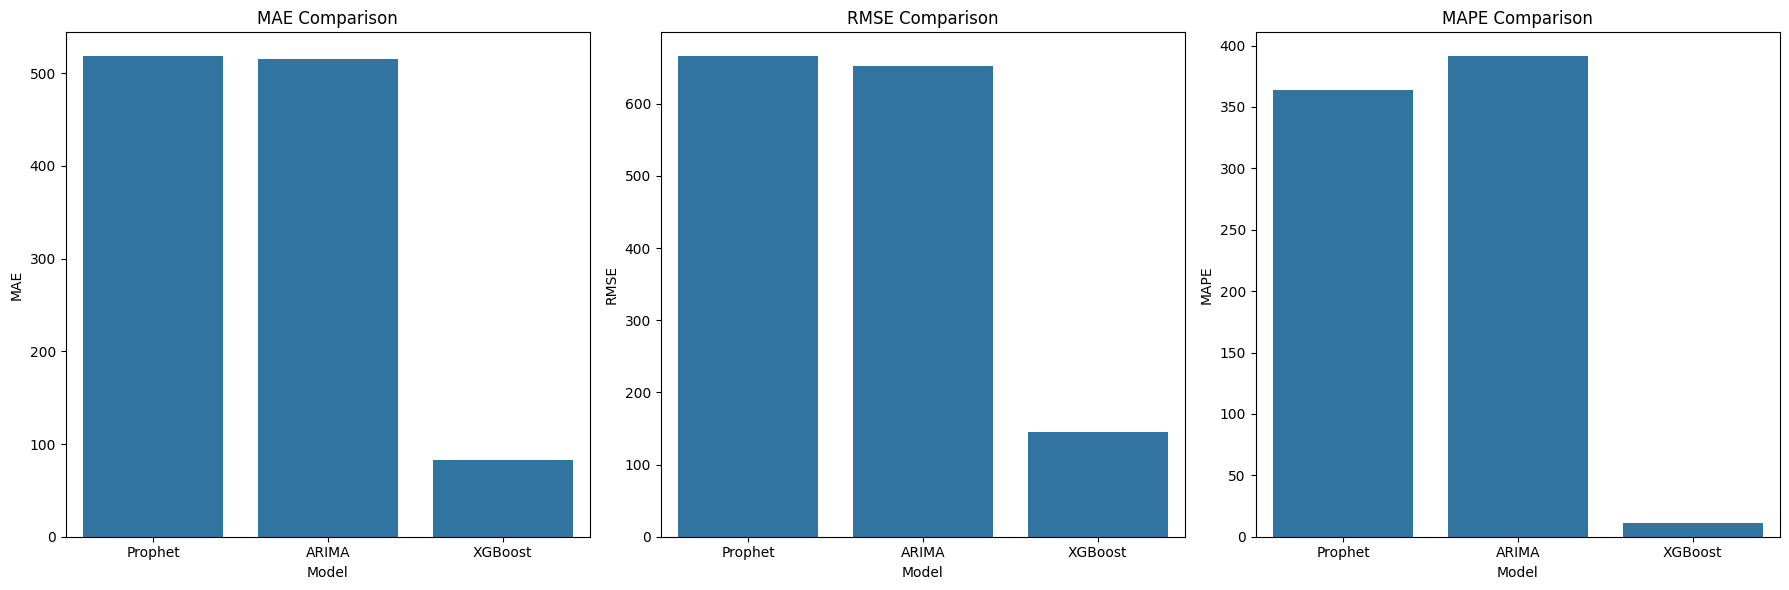


Best performing model based on MAPE: XGBoost


In [21]:
def compare_models(prophet_metrics, arima_metrics, xgb_metrics):
    """Compare performance of different forecasting models"""
    
    # Create comparison DataFrame
    comparison_data = []
    
    if prophet_metrics:
        comparison_data.append({
            'Model': 'Prophet',
            'MAE': prophet_metrics['MAE'],
            'RMSE': prophet_metrics['RMSE'],
            'MAPE': prophet_metrics['MAPE']
        })
    
    if arima_metrics:
        comparison_data.append({
            'Model': 'ARIMA',
            'MAE': arima_metrics['MAE'],
            'RMSE': arima_metrics['RMSE'],
            'MAPE': arima_metrics['MAPE']
        })
    
    if xgb_metrics:
        comparison_data.append({
            'Model': 'XGBoost',
            'MAE': xgb_metrics['MAE'],
            'RMSE': xgb_metrics['RMSE'],
            'MAPE': xgb_metrics['MAPE']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("Model Performance Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    metrics = ['MAE', 'RMSE', 'MAPE']
    for i, metric in enumerate(metrics):
        sns.barplot(data=comparison_df, x='Model', y=metric, ax=axes[i])
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_ylabel(metric)
    
    plt.tight_layout()
    plt.show()
    
    # Determine best model
    best_model = comparison_df.loc[comparison_df['MAPE'].idxmin(), 'Model']
    print(f"\nBest performing model based on MAPE: {best_model}")
    
    return comparison_df

# Compare all models
if all([prophet_metrics, arima_metrics, xgb_metrics]):
    model_comparison = compare_models(prophet_metrics, arima_metrics, xgb_metrics)


In [22]:
import joblib


In [23]:
# Examples (choose based on your selected model)
best_model = xgb_model       # For XGBoost
# best_model = prophet_model   # For Prophet
# best_model = arima_model     # For ARIMA


In [24]:
joblib.dump(best_model, 'best_model.pkl')
print("Best model saved as 'best_model.pkl'")


Best model saved as 'best_model.pkl'


In [38]:
# Use your uploaded CSV file
df = pd.read_csv('powerbi_sales_forecast_data.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')


In [39]:
# Create lag features: previous day's sales, previous week's sales, etc.
df['Sales_lag_1'] = df['Sales'].shift(1)
df['Sales_lag_7'] = df['Sales'].shift(7)

# Create rolling features
df['Sales_roll_7'] = df['Sales'].rolling(window=7).mean()
df['Sales_roll_30'] = df['Sales'].rolling(window=30).mean()

# Extract time/date features
df['dayofweek'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

# Drop initial NA rows from shifting/rolling
df = df.dropna()


In [40]:
# Forecast last ~3 months, for example
train = df.iloc[:-90]
test = df.iloc[-90:]

# Features and target
features = ['Sales_lag_1', 'Sales_lag_7', 'Sales_roll_7', 'Sales_roll_30', 'dayofweek', 'month', 'year']
X_train = train[features]
y_train = train['Sales']
X_test = test[features]
y_test = test['Sales']


In [41]:
# Create and train the regressor
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [42]:
y_pred = model.predict(X_test)


In [43]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.2f}")


Root Mean Squared Error: 607.91


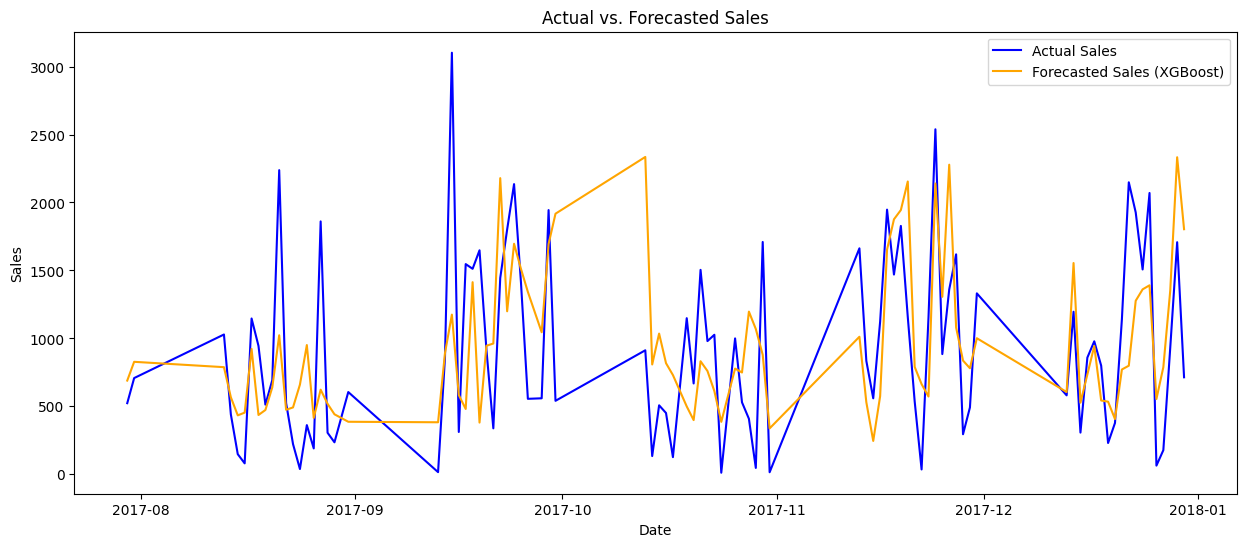

In [46]:
plt.figure(figsize=(15,6))
plt.plot(test['Date'], y_test, label='Actual Sales', color='blue')
plt.plot(test['Date'], y_pred, label='Forecasted Sales (XGBoost)', color='orange')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs. Forecasted Sales')
plt.show()


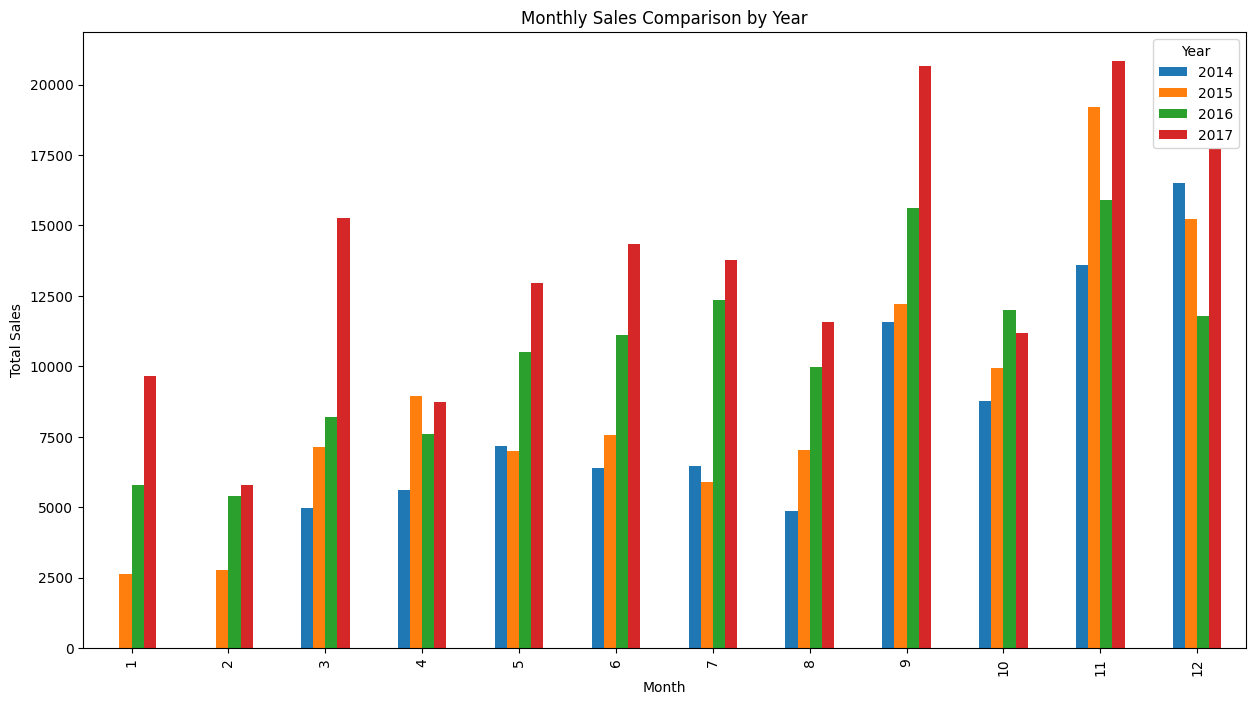

In [48]:
# Assume df with columns: 'Year', 'Month', 'Sales'
monthly_yearly = df.groupby(['Year', 'Month']).Sales.sum().unstack(0)
monthly_yearly.plot(kind='bar', figsize=(15,8))
plt.title("Monthly Sales Comparison by Year")
plt.ylabel("Total Sales")
plt.show()


In [ ]:
# monthly = df.groupby(['year', 'month'])['Sales'].sum().reset_index()
# pivot = monthly.pivot(index='month', columns='year', values='Sales')
# print(pivot)


year         2014        2015        2016        2017
month                                                
1             NaN   2624.1600   5790.8070   9638.2320
2             NaN   2761.7270   5389.2440   5796.1554
3       4957.0590   7145.5966   8200.4210  15270.1968
4       5617.0400   8953.2465   7587.5240   8716.9916
5       7185.1570   7001.3960  10494.0750  12943.4914
6       6397.5786   7548.4350  11114.6630  14335.3942
7       6476.7200   5888.4100  12367.3700  13770.9450
8       4871.6325   7019.5770   9983.2038  11578.1900
9      11572.7038  12215.1360  15620.7575  20643.3050
10      8757.3160   9944.7830  12012.5340  11181.4192
11     13582.2855  19202.5883  15909.7920  20827.1970
12     16495.9290  15223.6130  11792.2640  17716.1038


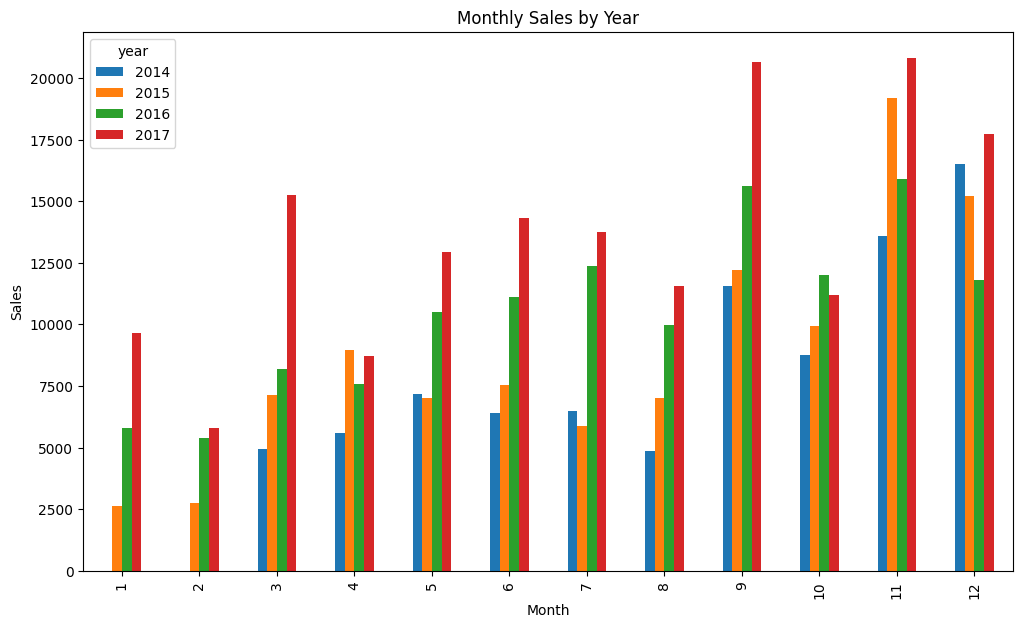

In [ ]:
# pivot.plot(kind='bar', figsize=(12,7))
# plt.title('Monthly Sales by Year')
# plt.ylabel('Sales')
# plt.xlabel('Month')
# plt.show()


In [ ]:
# selected_region = 'West'  # change to any region in your data
# df_region = df[df['Region'] == selected_region]
# # Now, use df_region for all summary/statistics/plots


In [49]:
# Filter example in pandas
selected_category = 'Furniture'
category_df = df[df['Category'] == selected_category]
# Now use category_df for your plots and analysis

# Optional: For interactivity (in Jupyter)
import ipywidgets as widgets
from IPython.display import display

def plot_filtered(category):
    filtered = df[df['Category'] == category]
    # Repeat your existing plots here with 'filtered'
    # Example: filtered.groupby('Month').Sales.sum().plot()

category_selector = widgets.Dropdown(options=df['Category'].unique(), description='Category:')
widgets.interact(plot_filtered, category=category_selector)


interactive(children=(Dropdown(description='Category:', options=('All',), value='All'), Output()), _dom_classe…

<function __main__.plot_filtered(category)>

In [52]:
import matplotlib.pyplot as plt

def plot_filtered(category):
    filtered = df[df['Category'] == category]
    # Clear current figure to avoid overplotting
    plt.figure(figsize=(10,5))
    # Basic example: monthly sales bar chart
    filtered.groupby('Month')['Sales'].sum().plot(kind='bar')
    plt.title(f"Monthly Sales for Category: {category}")
    plt.xlabel("Month")
    plt.ylabel("Total Sales")
    plt.tight_layout()
    # Make sure to display the plot
    plt.show()


In [53]:
import ipywidgets as widgets
from IPython.display import display

# Dropdown for category selection
category_selector = widgets.Dropdown(
    options=df['Category'].unique(),
    description='Category:',
    value=df['Category'].unique()[0] # set default value
)

# Attach the function to the widget for interactivity
widgets.interact(plot_filtered, category=category_selector)


interactive(children=(Dropdown(description='Category:', options=('All',), value='All'), Output()), _dom_classe…

<function __main__.plot_filtered(category)>

In [57]:
%matplotlib notebook
%matplotlib inline


In [ ]:
filtered.groupby('Region')['Sales'].sum().plot(kind='bar')
plt.title(f"Sales by Region for Category: {category}")


In [61]:
print(df.columns)


Index(['Date', 'Sales', 'Type', 'Category', 'Region', 'Store', 'Year', 'Month',
       'Quarter', 'MonthName', 'Sales_lag_1', 'Sales_lag_7', 'Sales_roll_7',
       'Sales_roll_30', 'dayofweek', 'month', 'year'],
      dtype='object')


In [62]:
top_categories = df.groupby('Category')['Sales'].sum().sort_values(ascending=False).head(10)
print("Top Categories by Sales:\n", top_categories)


Top Categories by Sales:
 Category
All    480122.3665
Name: Sales, dtype: float64


In [63]:
top_regions = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)
print("Top Regions by Sales:\n", top_regions)


Top Regions by Sales:
 Region
All    480122.3665
Name: Sales, dtype: float64


In [64]:
top_stores = df.groupby('Store')['Sales'].sum().sort_values(ascending=False)
print("Top Stores by Sales:\n", top_stores)


Top Stores by Sales:
 Store
All    480122.3665
Name: Sales, dtype: float64


In [65]:
low_months = df.groupby('MonthName')['Sales'].sum().sort_values().head(3)
print("Lowest Sales Months:\n", low_months)


Lowest Sales Months:
 MonthName
February    13947.1264
January     18053.1990
April       30874.8021
Name: Sales, dtype: float64


<Axes: xlabel='Year'>

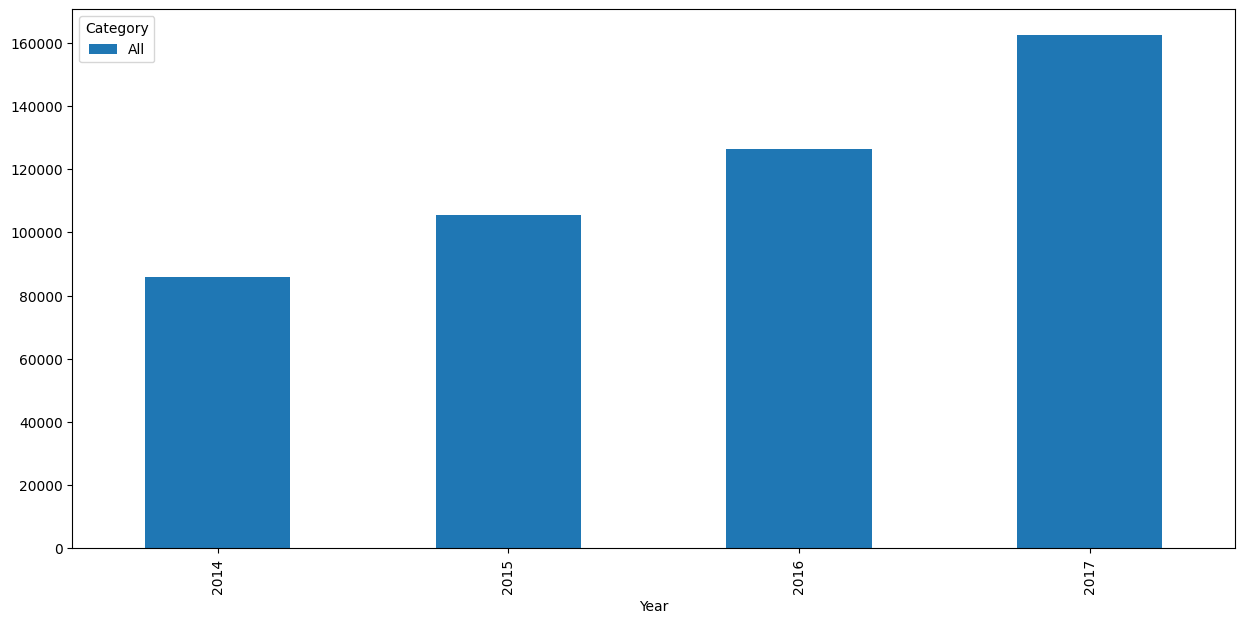

In [66]:
# Yearly sales by Category
df.groupby(['Year', 'Category'])['Sales'].sum().unstack('Category').plot(kind='bar', figsize=(15,7))


In [67]:
# Top-selling categories
print("Top Categories by Total Sales:")
print(df.groupby('Category')['Sales'].sum().sort_values(ascending=False))

# Low sales months
print("Lowest Sales Months:")
print(df.groupby('MonthName')['Sales'].sum().sort_values().head(3))


Top Categories by Total Sales:
Category
All    480122.3665
Name: Sales, dtype: float64
Lowest Sales Months:
MonthName
February    13947.1264
January     18053.1990
April       30874.8021
Name: Sales, dtype: float64


In [ ]:
# total_sales = df['Sales'].sum()
# average_monthly = df.groupby('Month').Sales.sum().mean()
# best_month = df.groupby('Month').Sales.sum().idxmax()
# worst_month = df.groupby('Month').Sales.sum().idxmin()

# print(f"Total Sales: {total_sales:.2f}")
# print(f"Average Monthly Sales: {average_monthly:.2f}")
# print(f"Best Month: {best_month}")
# print(f"Worst Month: {worst_month}")


Total Sales: 480122.37
Average Monthly Sales: 40010.20
Best Month: 11
Worst Month: 2


In [74]:
top_months = df.groupby('MonthName')['Sales'].sum().sort_values(ascending=False)
print('Top months:\n', top_months.head(3))


Top months:
 MonthName
November     69521.8628
December     61227.9098
September    60051.9023
Name: Sales, dtype: float64


In [75]:
low_months = df.groupby('MonthName')['Sales'].sum().sort_values()
print('Lowest months:\n', low_months.head(3))


Lowest months:
 MonthName
February    13947.1264
January     18053.1990
April       30874.8021
Name: Sales, dtype: float64


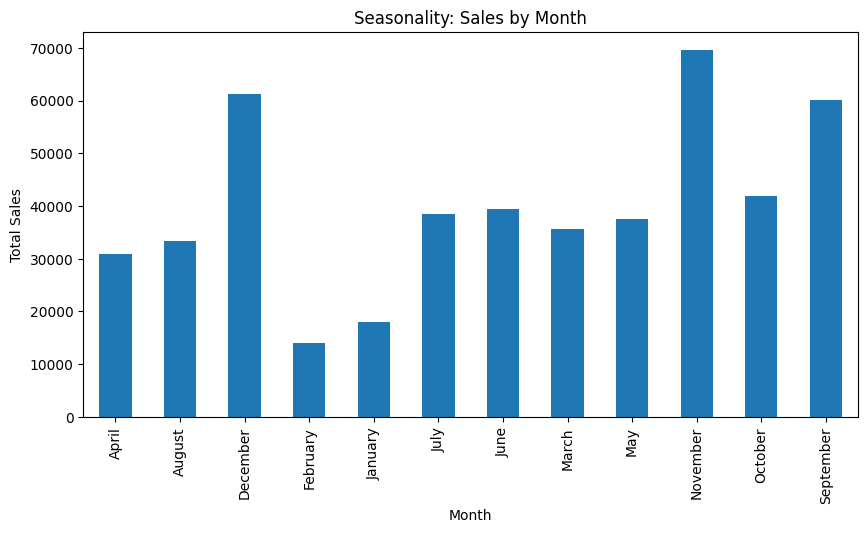

In [76]:
df.groupby('MonthName')['Sales'].sum().plot(kind='bar', figsize=(10,5))
plt.title('Seasonality: Sales by Month')
plt.ylabel('Total Sales')
plt.xlabel('Month')
plt.show()


In [77]:
total_sales = df['Sales'].sum()
avg_monthly_sales = df.groupby(['year', 'month'])['Sales'].sum().mean()
best_month = df.groupby('MonthName')['Sales'].sum().idxmax()
worst_month = df.groupby('MonthName')['Sales'].sum().idxmin()
print(f"Total Sales: {total_sales:.2f}")
print(f"Average Monthly Sales: {avg_monthly_sales:.2f}")
print(f"Best Month (Total Sales): {best_month}")
print(f"Worst Month (Total Sales): {worst_month}")


Total Sales: 480122.37
Average Monthly Sales: 10437.44
Best Month (Total Sales): November
Worst Month (Total Sales): February


In [78]:
kpi_summary = {
    "Total Sales": total_sales,
    "Average Monthly Sales": avg_monthly_sales,
    "Best Month": best_month,
    "Worst Month": worst_month
}
import pandas as pd
kpi_df = pd.DataFrame.from_dict(kpi_summary, orient='index', columns=['Value'])
print(kpi_df)


                             Value
Total Sales            480122.3665
Average Monthly Sales  10437.44275
Best Month                November
Worst Month               February
